In [1]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
theano.config.gcc__cxxflags += " -fexceptions"
theano.config.on_opt_error = "raise"
theano.tensor.opt.constant_folding
theano.graph.opt.EquilibriumOptimizer
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from tqdm import tqdm
from theano.tensor.random.utils import RandomStream
import scipy.linalg as sl
import scipy.stats as ss
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.linalg import svd

starry.config.quiet = True
np.random.seed(1)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
def _cho_solve(L, b):
    return tt.slinalg.solve_upper_triangular(L.T, tt.slinalg.solve_lower_triangular(L, b))

class StarryStarryProcess(object):
    def __init__(self, sys, sp, nt, nlm):
        self._sys = sys
        self._sp = sp
        self._nt = nt
        self._nlm = nlm

        self._mu = sp.mean_ylm
        self._Lambda = sp.cov_ylm

    @property
    def nt(self):
        return self._nt
    @property
    def nlm(self):
        return self._nlm

    @property
    def sys(self):
        return self._sys
    @property
    def sp(self):
        return self._sp
    
    @property
    def mu(self):
        return self._mu
    @property
    def Lambda(self):
        return self._Lambda
    
    @property
    def primary(self):
        return self.sys.primary
    @property
    def secondary(self):
        return self.sys.secondaries[0]
    
    @property
    def design_matrix(self):
        return self._M

    @property
    def logl_marginal(self):
        return self._logl_marginal
    @property
    def a(self):
        return self._a
    @property
    def AInv_chol(self):
        return self._AInv_chol

    def _compute(self, t, flux, sigma_flux):
        M = self.sys.design_matrix(t)[:,:-1] # We don't use any flux from the secondary, so [:, :-1]
        self._M = M

        nlm = self.nlm
        nt = self.nt

        mu = self.mu
        Lambda = self.Lambda

        # We want to enforce that the prior on the constant term in the map is
        # completely flat, so we set the first row and column of the precision
        # matrix to zero we do this manually here.  First we Cholesky decompose:
        #
        # Lambda[1:,1:] = L L^T
        #
        # Then, because of a quirk of theano (no gradients for `cho_solve!`,
        # WTF), we can compute Lambda[1:,1:]^{-1} via
        #
        # Lambda[1:,1:]^{-1} = tt.slinalg.solve_triangular(L.T, tt.slinalg.solve_triangular(L, tt.eye(nlm-1), lower=True), lower=False)
        #
        # encapsulated in our _cho_solve(...) function above
        L = tt.slinalg.cholesky(Lambda[1:,1:])
        Lambda_inv = _cho_solve(L, tt.eye(nlm-1))
        Lambda_inv = tt.set_subtensor(tt.zeros((nlm, nlm))[1:,1:], Lambda_inv)

        sigma_flux2 = tt.square(sigma_flux)
        MTCinv = M.T / sigma_flux2[None, :]
        MTCinvM = tt.dot(MTCinv, M)

        AInv = Lambda_inv + MTCinvM
        AInv_chol = tt.slinalg.cholesky(AInv)
        a = _cho_solve(AInv_chol, tt.dot(Lambda_inv, mu) + tt.dot(MTCinv, flux))

        self._a = a
        self._AInv_chol = AInv_chol

        b = tt.dot(M, mu)
        r = flux - b

        Cinvr = r / sigma_flux2

        rtilde = Cinvr - tt.dot(MTCinv.T, tt.slinalg.solve(AInv, tt.dot(MTCinv, r)))

        # Identity:
        # |B| = |I + M^T C^-1 M L| |C| = |L^-1 + M^T C^-1 M| |L| |C|
        # But we want to cancel the infinite constant in L[0,0], so we ignore the first row and column of L:
        # |B| = | A^-1 | |L[1:,1:]| |C|

        logdetB = tt.sum(tt.log(sigma_flux2)) + 2*tt.sum(tt.log(tt.diag(AInv_chol))) + 2*tt.sum(tt.log(tt.diag(L)))

        # (nt-1) because we have cancelled one dimension due to the flat prior on the [0,0] constant term.
        logl = -0.5*tt.dot(r, rtilde) - 0.5*logdetB - 0.5*(nt-1)*tt.log(2*np.pi)
        self._logl_marginal = logl

    def marginal_likelihood(self, t, flux, sigma_flux):
        self._compute(t, flux, sigma_flux)
        return self.logl_marginal
    
    def sample_ylm_conditional(self, t, flux, sigma_flux, size=1, rng=None):
        if rng is None:
            rng = RandomStream(seed=np.random.randint(1<<32))

        nylm = self.nlm

        self._compute(t, flux, sigma_flux)
        return self.a[None,:] + tt.slinalg.solve_upper_triangular(self.AInv_chol.T, rng.normal(size=(nylm, size))).T

In [30]:
class Star(object):
    starry.config.lazy = False
    def __init__(
        self, t, error=1e-8, nlon=300, ydeg=15, linear=True, eps=1e-12, smoothing=0.1, planet=True
    ):
        # Generate a uniform intensity grid
        self.nlon = nlon
        self.nlat = nlon // 2
        self.lon = np.linspace(-180, 180, self.nlon)
        self.lat = np.linspace(-90, 90, self.nlat)
        self.lon, self.lat = np.meshgrid(self.lon, self.lat)
        self.intensity = np.zeros_like(self.lat)
        self.linear = linear
        self.t = t
        self.err = error

        # Instantiate a starry map
        self.map = starry.Map(ydeg, 2)

        # cos(lat)-weighted SHT
        w = np.cos(self.lat.flatten() * np.pi / 180)
        P = self.map.intensity_design_matrix(
            lat=self.lat.flatten(), lon=self.lon.flatten()
        )
        PTSinv = P.T * (w ** 2)[None, :]
        self.Q = np.linalg.solve(PTSinv @ P + eps * np.eye(P.shape[1]), PTSinv)
        if smoothing > 0:
            l = np.concatenate(
                [np.repeat(l, 2 * l + 1) for l in range(ydeg + 1)]
            )
            s = np.exp(-0.5 * l * (l + 1) * smoothing ** 2)
            self.Q *= s[:, None]

        self.star = starry.Primary(self.map, r=1, m=1) 
        self.map[1] = 0.4
        self.map[2] = 0.2
        if planet:
            self.planet = starry.Secondary(
                starry.Map(0,0),
                inc=90,
                ecc=0,
                r=0.1,
                m=1e-3,
                prot=1.0,
                porb = 5.
            )

            self.sys = starry.System(self.star, self.planet)
        
        sp = StarryProcess(
            mu=30,
            sigma=1,
            r=20,
            dr=5.,
            c=0.5,
            n=1,
        )

        nt = len(t)
        self.ssp = StarryStarryProcess(self.sys, sp, nt, len(self.map.y))

        self.y_true = sp.sample_ylm().eval().reshape(-1)
        self.y_true[0] += 1

    def _angular_distance(self, lam1, lam2, phi1, phi2):
        # https://en.wikipedia.org/wiki/Great-circle_distance
        return (
            np.arccos(
                np.sin(phi1 * np.pi / 180) * np.sin(phi2 * np.pi / 180)
                + np.cos(phi1 * np.pi / 180)
                * np.cos(phi2 * np.pi / 180)
                * np.cos((lam2 - lam1) * np.pi / 180)
            )
            * 180
            / np.pi
        )

    def get_y(self):
        flux = self.sys.design_matrix(self.t)[:, :-1] @ self.y_true
        sigma_flux = self.err*np.ones_like(flux)
        return self.ssp.sample_ylm_conditional(self.t, flux, sigma_flux=sigma_flux)[0,:]
    
    def reset(self):
        self.intensity = np.zeros_like(self.lat)


In [28]:
obls = [0, 10, 30, 45, 60, 90]

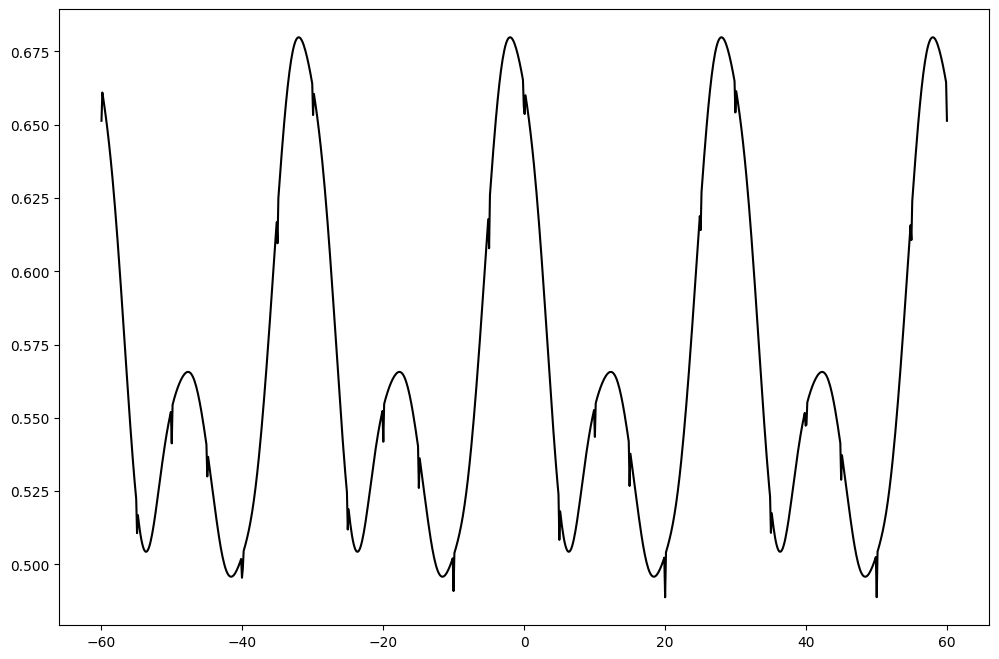

In [12]:
rng = np.random.default_rng(302592346730275158208684369480422136411)
t = np.linspace(-60, 60, 1000)
theta = (360 * t / 30) % 360
# Instantiate maps at low and high degree
star = Star(t=t, ydeg=15, smoothing=0.1)
star.planet.porb = 5.
star.planet.t0 = 0.
star.star.prot = 30
y = star.get_y()
star.map[:,:] = y.eval()
flux = star.sys.design_matrix(t)[:,:-1] @ y.eval()
plt.figure(figsize=(12,8))
plt.plot(t, flux, 'k-')

In [114]:
star.sys.show(t=t)

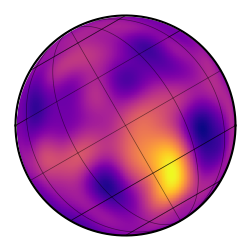

In [45]:
t = np.linspace(0, 1, 1000, endpoint=False)
# Instantiate maps at low and high degree
star = Star(t=t, ydeg=15, smoothing=0.1)
star.map.obl = 30
y = star.get_y()
star.map[:,:] = y.eval().reshape(-1)
star.map.show()

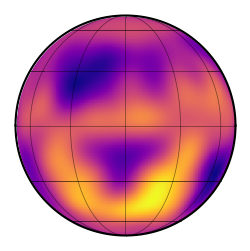

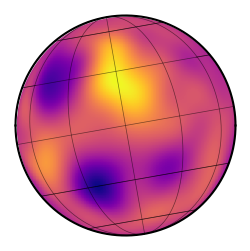

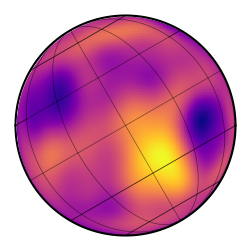

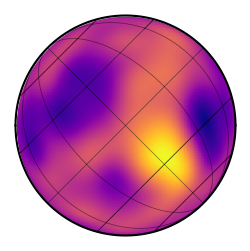

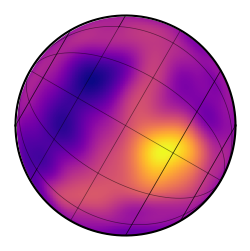

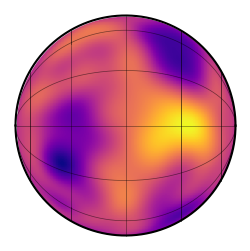

In [50]:
# stars
stars = [None, None, None, None, None, None]
# The Ylm coeffs for each star
y = [None, None, None, None, None, None]

# Loop over stars
for n, obl in enumerate(obls):
    stars[n] = Star(t=t, ydeg=15, smoothing=0.1)
    stars[n].reset()
    stars[n].map.obl = obl
    y = stars[n].get_y()
    stars[n].map[:,:] = y.eval().reshape(-1)
    stars[n].map.show()

In [59]:
y[0].eval().reshape(-1).shape

(1,)

In [64]:
stars[0].get_y().eval()

array([ 4.89188420e-01,  2.87328336e-01,  1.42468553e-01, -4.80971854e-02,
       -5.31483332e-03, -1.93948314e-01,  2.52619669e-02,  1.55475370e-02,
       -1.30731687e-01,  2.48338124e-01,  1.75577962e-01,  1.59368596e-01,
       -6.17161506e-02,  1.75381401e-01, -5.48406038e-02, -7.94176392e-02,
        6.46471581e-02, -1.72199373e-01, -1.39176678e-01,  8.07925043e-02,
        1.75201924e-01,  5.22212321e-02,  1.29916381e-01,  3.40993612e-02,
        2.18237347e-01,  1.99225079e-02,  6.77191007e-02,  9.82495625e-02,
        4.71750286e-02, -5.41069645e-02, -3.70702669e-02, -3.47053143e-02,
       -1.23416818e-01, -1.01025184e-01, -4.10714062e-02,  4.31410994e-02,
        1.51608932e-02, -2.52547988e-02,  1.44298675e-03,  9.44753210e-02,
        4.57284669e-02,  3.28732163e-02,  3.40957825e-02,  2.80021276e-02,
        4.16940275e-02, -4.86324002e-02,  1.34042716e-01,  7.53226094e-02,
        1.29904297e-01, -2.81355281e-02,  3.29968349e-02, -2.41435470e-02,
       -5.81423988e-02, -

In [68]:
stars[0].planet.Omega = 10

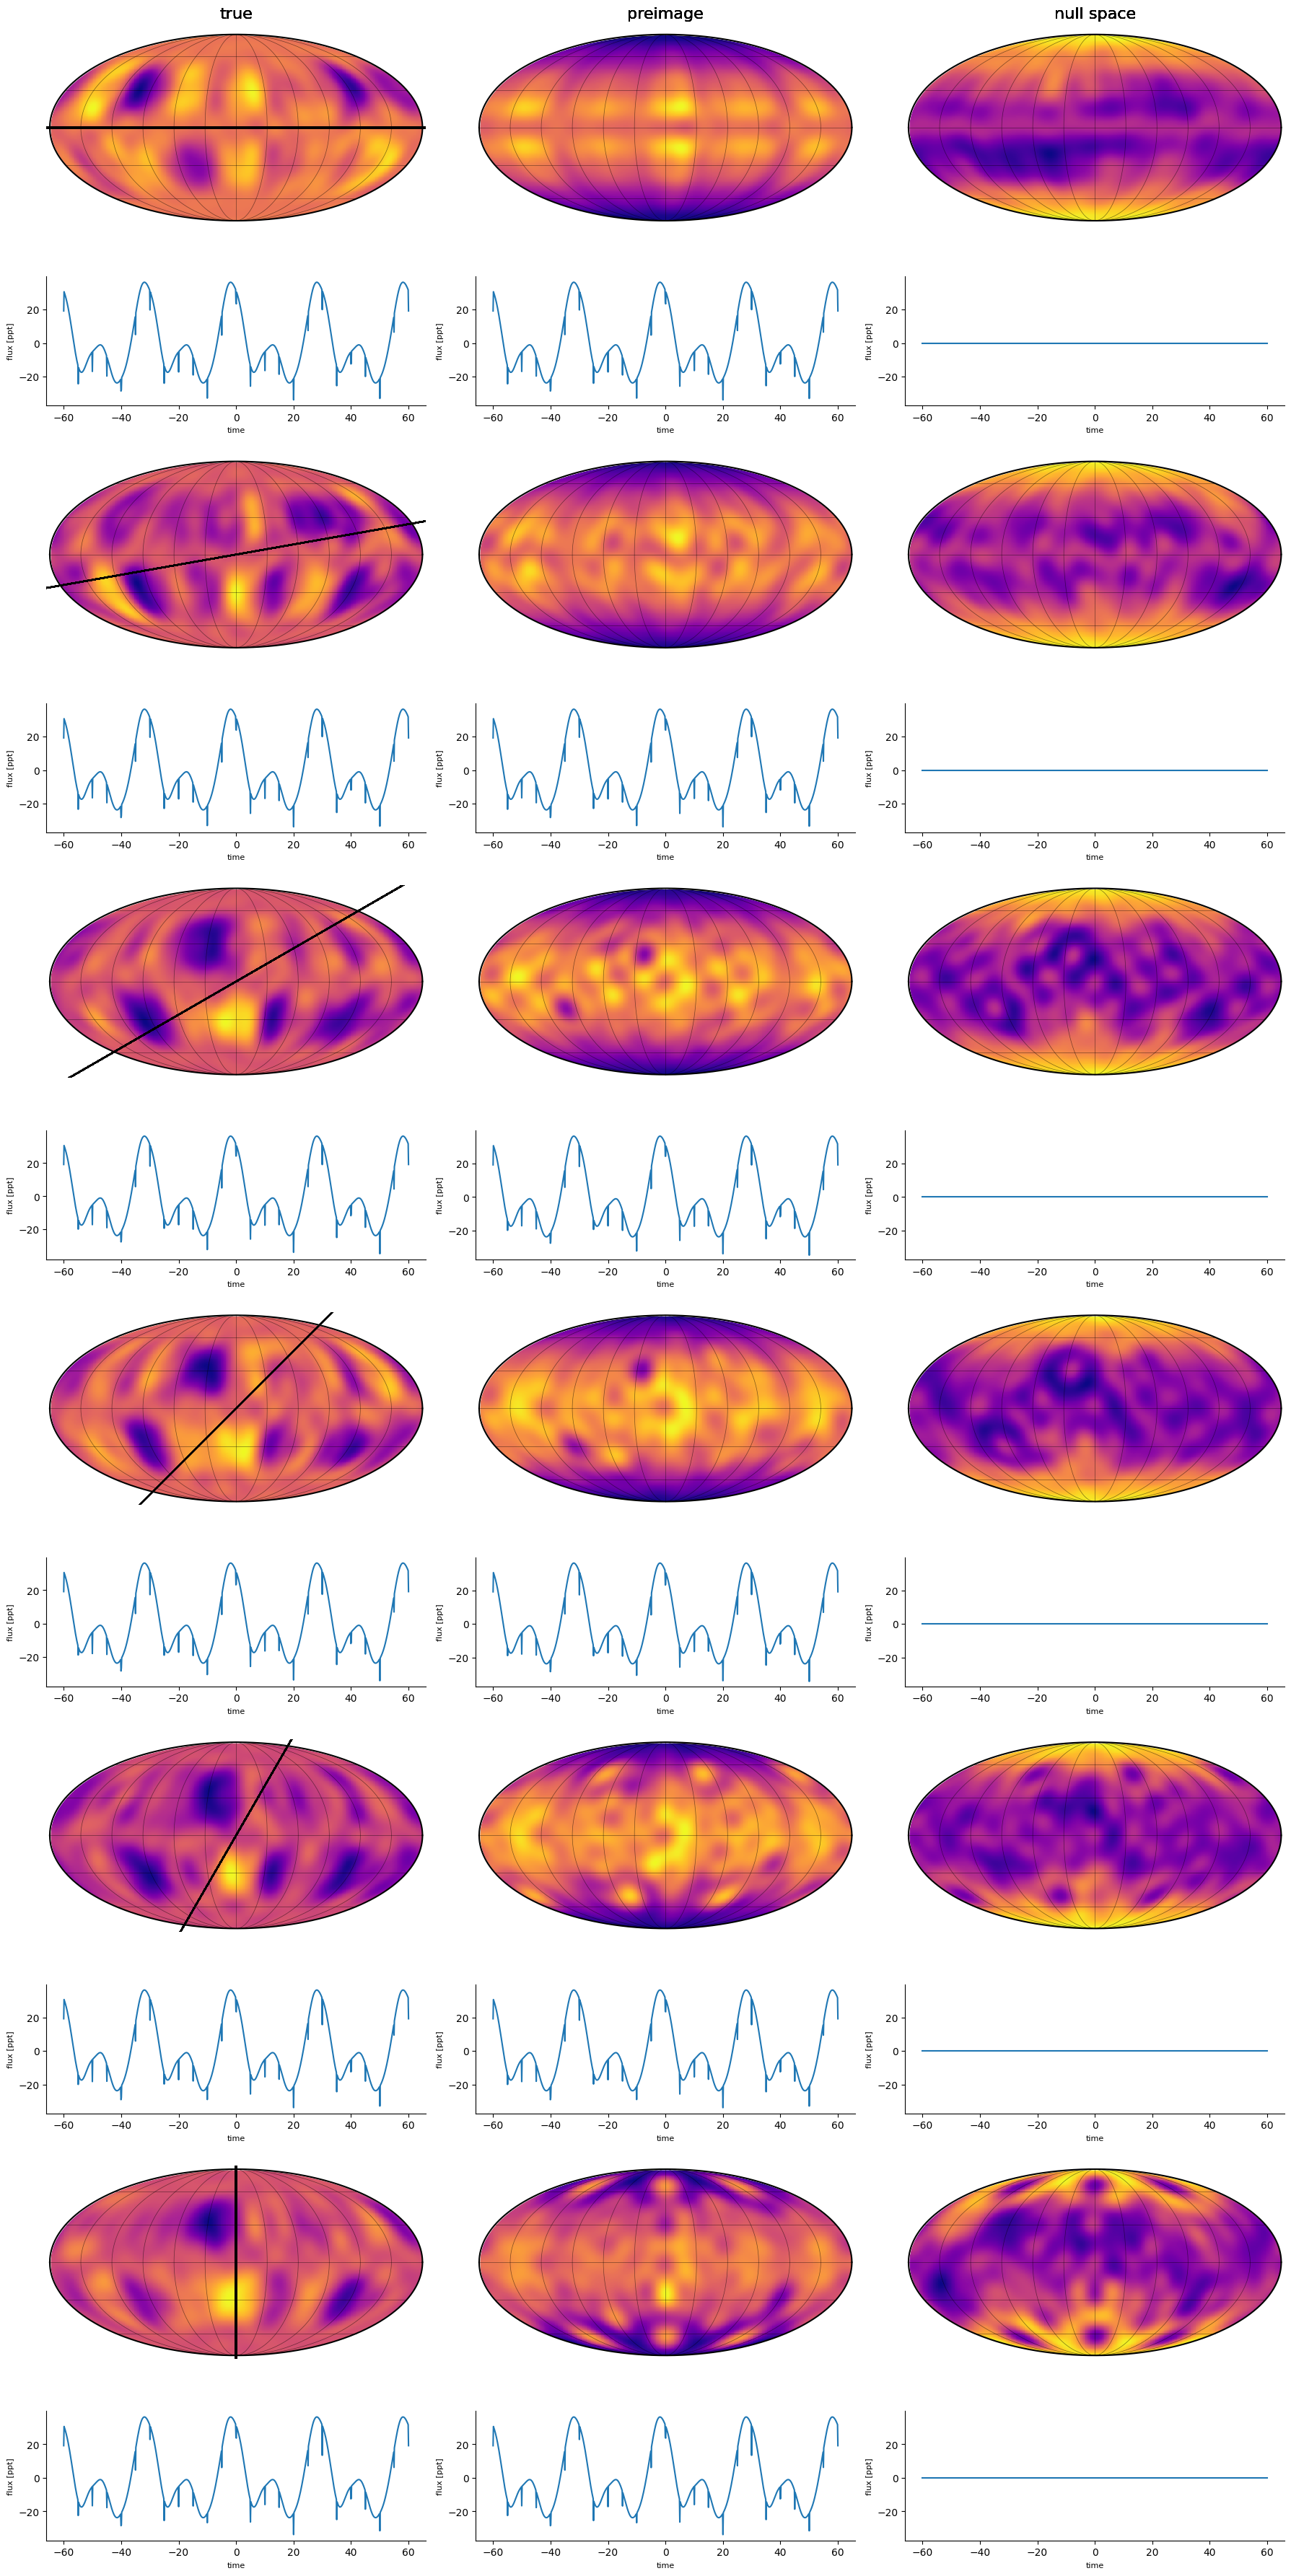

In [31]:
# stars
stars = [None, None, None, None, None, None]
# The Ylm coeffs for each star
y = [None, None, None, None, None, None]

# fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig, ax = plt.subplots(
        12, 3, figsize=(18, 36), gridspec_kw={"height_ratios": [1, 0.5] * 6}
    )
# Loop over each star
for k, obl in enumerate(obls):
    
   # Set up the figure
    # fig, ax = plt.subplots(
    #     2, 3, figsize=(12, 3), gridspec_kw={"height_ratios": [1, 0.5]}
    # )

    # Compute the null space operators
    t = np.linspace(-60, 60, 1000)
    theta = (360 * t / 30) % 360
    stars[k] = Star(t=t, smoothing=0.1)
    stars[k].reset()
    # stars[k].map.obl = obl
    stars[k].planet.Omega = obl
    stars[k].planet.porb = 5.
    stars[k].planet.t0 = 0.
    stars[k].star.prot = 30
    
    y[k] = stars[k].get_y()

    # A = stars[k].map.design_matrix(theta=theta)
    A = stars[k].sys.design_matrix(t)[:, :-1]
    rank = np.linalg.matrix_rank(A)
    _, _, VT = svd(A)
    N = VT[rank:].T @ VT[rank:]  # null space operator
    R = VT[:rank].T @ VT[:rank]  # row space operator


    # True map
    stars[k].map[:,:] = y[k].eval()
    image = stars[k].map.render(projection="moll")
    image += 1 - np.nanmedian(image)

    xo, yo, zo = stars[k].sys.position(t)
    xo = xo[1]
    yo = yo[1]
    zo = zo[1]
    idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
    # ax[0, 0].plot(xo[idx], yo[idx], "k-", ms=1);
    # ax[0, 0].set_aspect(1)
    # ax[0, 0].axis("off")

    ax[k*2, 0].plot(xo[idx], yo[idx], "k-", ms=1);
    ax[k*2, 0].set_aspect(1)
    ax[k*2, 0].axis("off")


    # idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
    # lat = 180 / np.pi * np.arcsin(yo[idx])
    # lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
    # lon = (lon + 180) % 360 - 180
    # mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
    # mask[mask == 1] = np.nan
    # ax[0,0].plot(lon, lat + mask, "k-");

    # stars[k].map.show(ax=ax[0, 0], image=image, projection="moll")
    stars[k].map.show(ax=ax[k*2, 0], image=image, projection="moll")
    ax[0, 0].annotate(
        "true",
        xy=(0.5, 1.0),
        xycoords="axes fraction",
        xytext=(0, 10),
        textcoords="offset points",
        va="bottom",
        ha="center",
        fontsize=16,
    )
    # flux = stars[k].map.flux(theta=theta)
    # flux -= np.mean(flux)
    # flux *= 1e3
    flux = stars[k].sys.design_matrix(t)[:, :-1] @ y[k].eval()
    flux -= np.mean(flux)
    flux *= 1e3
    # ax[1, 0].plot(t, flux)
    ax[k * 2 + 1, 0].plot(t, flux)
    ymax = 1.2 * np.max(np.abs(flux))
 

    # row space only
    stars[k].map[:, :] = R @ y[k].eval()
    image = stars[k].map.render(projection="moll")
    image += 1 - np.nanmedian(image)
    stars[k].map.show(ax=ax[k*2, 1], image=image, projection="moll")
    ax[0, 1].annotate(
        "preimage",
        xy=(0.5, 1.0),
        xycoords="axes fraction",
        xytext=(0, 10),
        textcoords="offset points",
        va="bottom",
        ha="center",
        fontsize=16,
    )
    # flux = stars[k].map.flux(theta=theta)
    # flux -= np.mean(flux)
    # flux *= 1e3
    flux = stars[k].sys.design_matrix(t)[:, :-1] @ (R @ y[k].eval())
    flux -= np.mean(flux)
    flux *= 1e3
    # ax[1, 1].plot(t, flux)

    # ax[1, 1].set_ylim(*ax[1, 0].get_ylim())

    ax[k*2+1, 1].plot(t, flux)

    ax[k*2+1, 1].set_ylim(*ax[1, 0].get_ylim())

    # Null space only
    stars[k].map[:, :] = N @ y[k].eval()
    image = stars[k].map.render(projection="moll")
    image += 1 - np.nanmedian(image)
    stars[k].map.show(ax=ax[k*2, 2], image=image, projection="moll")
    ax[0, 2].annotate(
        "null space",
        xy=(0.5, 1.0),
        xycoords="axes fraction",
        xytext=(0, 10),
        textcoords="offset points",
        va="bottom",
        ha="center",
        fontsize=16,
    )
    # flux = stars[k].map.flux(theta=theta)
    # flux -= np.mean(flux)
    # flux *= 1e3
    flux = stars[k].sys.design_matrix(t)[:, :-1] @ (N @ y[k].eval())
    flux -= np.mean(flux)
    flux *= 1e3
    # ax[1, 2].plot(t, flux)

    # ax[1, 2].set_ylim(*ax[1, 0].get_ylim())

    ax[k*2+1, 2].plot(t, flux)

    ax[k*2+1, 2].set_ylim(*ax[1, 0].get_ylim())

    # Appearance
    for n in range(3):
        ax[k*2+1, n].spines["top"].set_visible(False)
        ax[k*2+1, n].spines["right"].set_visible(False)
        ax[k*2+1, n].set_xlabel("time", fontsize=8)
        ax[k*2+1, n].set_ylabel("flux [ppt]", fontsize=8)
        # ax[1, n].set_xticks([0, 0.5, 1, 2, 3])
        # for tick in (
        #     ax[1, n].xaxis.get_major_ticks()
        #     + ax[1, n].yaxis.get_major_ticks()
        # ):
        #     tick.label.set_fontsize(6)
        # ax[1, n].tick_params(direction="in")
        ax[k*2, n].set_rasterization_zorder(2)
    
    # Remove empty space between subplots
    plt.tight_layout()



In [142]:
N.shape

(256, 256)

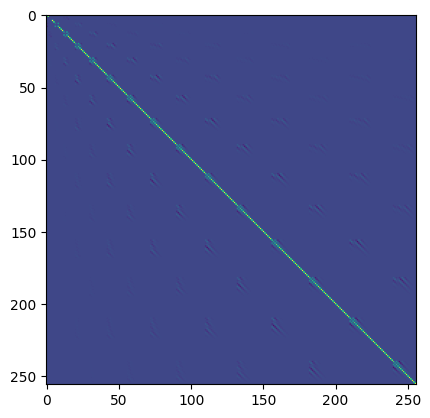

In [143]:
plt.imshow(N)

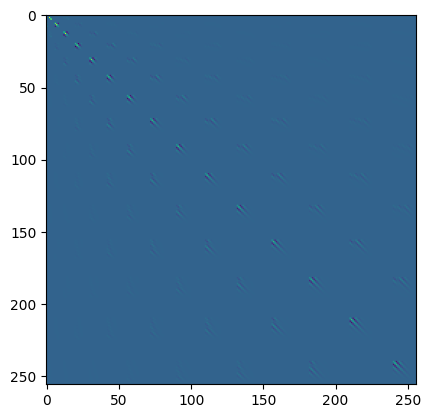

In [144]:
plt.imshow(R)

100%|██████████| 4/4 [00:25<00:00,  6.41s/it]
/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_17582/1648374241.py:38: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(10)
/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_17582/1648374241.py:39: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_rotation(30)
/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_17582/1648374241.py:41: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(10)


(0.0, 255.0)

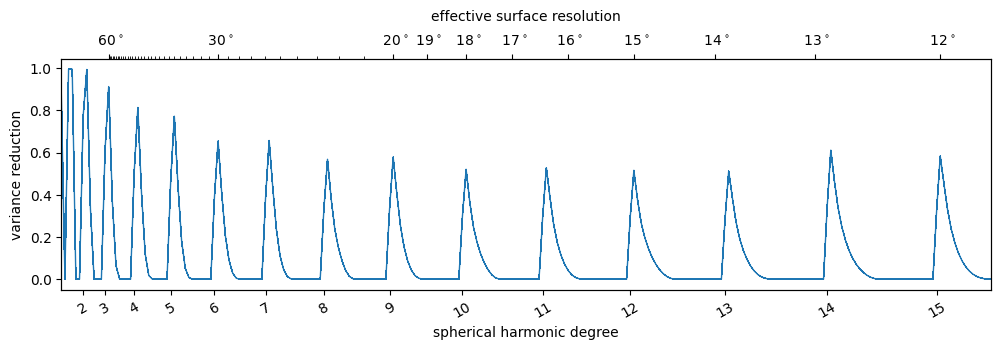

In [151]:
# Settings
ntheta = 50
ydeg = 15
ydeg_pad = 3
L = 1e9
C = 1
ninc = [1, 3, 10, 30]
kpn = 300
clobber = False

S = np.empty((len(ninc), kpn, map.Ny))
np.random.seed(0)
for n in tqdm(
    range(len(ninc)), disable=bool(int(os.getenv("NOTQDM", "0")))
):
    for k in range(kpn):
        A = np.empty((0, stars[0].map.Ny))
        A = np.vstack((A, stars[0].map.design_matrix(theta=theta)))
        cho_C = starry.linalg.solve(
            design_matrix=A,
            data=np.random.randn(A.shape[0]),
            C=C,
            L=L,
            N=stars[0].map.Ny,
        )[1]
        S[n, k] = 1 - np.diag(cho_C @ cho_C.T) / L
S = np.array(S, dtype="float32")


# Plot for just a *single* orientation
fig, ax = plt.subplots(1, figsize=(12, 3))
for k in range(kpn):
    ax.plot(S[0, k], color="C{}".format(0), lw=0.75, alpha=0.01, zorder=-1)
ax.plot(np.mean(S[0], axis=0), color="C{}".format(0), lw=1, zorder=1)
ax.set_rasterization_zorder(0)
ax.set_xlim(0, (ydeg + 1) ** 2 - 1)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
    tick.label.set_rotation(30)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
l = np.arange(2, ydeg + 1)
ax.set_xticks(l ** 2 + l)
ax.set_xticklabels(["{}".format(l) for l in np.arange(2, ydeg + 1)])
ax.set_xlabel("spherical harmonic degree")
ax.set_ylabel("variance reduction")

# Top axis
axt = ax.twiny()
xticks = np.array([60, 30, 20, 19, 18, 17, 16, 15, 14, 13, 12])
xticks_minor = np.arange(60, 12, -1)
xticklabels = [r"$\,\,${:.0f}$^\circ$".format(x) for x in xticks]
axt.set_xticks((180 / xticks_minor + 1) ** 2 - 180 / xticks_minor, minor=True)
axt.set_xticks((180 / xticks + 1) ** 2 - 180 / xticks)
axt.set_xticklabels(xticklabels, fontsize=10)
axt.set_xlabel(r"effective surface resolution", labelpad=10)
axt.set_xlim(*ax.get_xlim())


100%|██████████| 1/1 [01:01<00:00, 61.04s/it]


Text(0, 0.5, 'variance reduction')

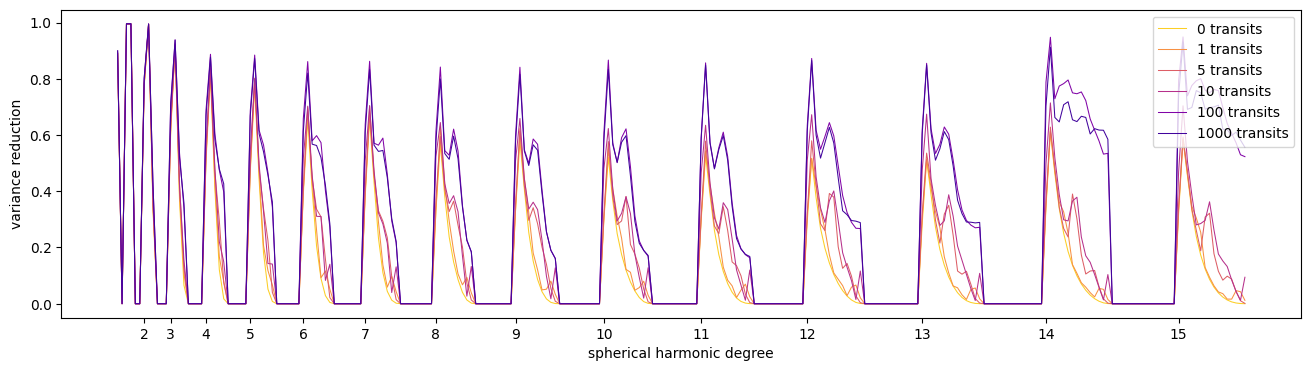

In [178]:
# Settings
ntheta = 50
ydeg = 15
ydeg_pad = 3
L = 1e9
C = 1
ninc = [1]
kpn = 300
clobber = False

ntran = [0, 1, 5, 10, 100, 1000]

cmap = plt.get_cmap("plasma_r")
color = lambda i: cmap(0.1 + 0.8 * i / (len(ntran) - 1))


S = np.empty((len(ninc), len(ntran), map.Ny))
np.random.seed(0)
for n in tqdm(
    range(len(ninc)), disable=bool(int(os.getenv("NOTQDM", "0")))
):
    for k in range(len(ntran)):
        t = np.linspace(-60, 60, 1000)
        theta = (360 * t / 30) % 360
        starp = Star(t=t, ydeg=15, smoothing=0.1)
        if k == 0:
            starp.planet.porb = 0
        else:
            starp.planet.porb = 120 / ntran[k]
        starp.planet.t0 = 0.
        starp.star.prot = 30
        y = starp.get_y()
        starp.map[:,:] = y.eval()
        
        A = np.empty((0, starp.map.Ny))
        A = np.vstack((A, starp.sys.design_matrix(t=t)[:,:-1]))
        cho_C = starry.linalg.solve(
            design_matrix=A,
            data=np.random.randn(A.shape[0]),
            C=C,
            L=L,
            N=starp.map.Ny,
        )[1]
        S[n, k] = 1 - np.diag(cho_C @ cho_C.T) / L
S = np.array(S, dtype="float32")


# Plot for just a *single* orientation
fig, ax = plt.subplots(1, figsize=(16, 4))
for k in range(len(ntran)):
    ax.plot(S[0, k], color=color(k), lw=0.75, alpha=1, zorder=-1, label=str(ntran[k])+" transits")
# ax.plot(np.mean(S[0], axis=0), color="C{}".format(0), lw=1, zorder=1)
ax.set_rasterization_zorder(0)

# Modify the legend size and position
legend = ax.legend(fontsize=0.5, borderaxespad=0.1)
legend.get_frame().set_alpha(0.5)  

# Place the legend in the upper right corner
ax.legend(loc='upper right')

l = np.arange(2, ydeg + 1)
ax.set_xticks(l ** 2 + l)
ax.set_xticklabels(["{}".format(l) for l in np.arange(2, ydeg + 1)])
ax.set_xlabel("spherical harmonic degree")
ax.set_ylabel("variance reduction")
